In [125]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.auto import tqdm

seed = 1234
torch.manual_seed(seed)

# Variables

In [176]:
PATH = './'
PATH_MODELS = PATH + '/models'
PATH_MESHES = PATH + '/meshes'
PATH_RESULTS = PATH + '/results'
PATH_CHECKPOINTS_GEN = PATH + '/checkpoints/gen'
PATH_CHECKPOINTS_DIS = PATH + '/checkpoints/dis'


learning_rate = 0.00001
epochs = 10

mean_gen_loss = 0
mean_dis_loss = 0

LAMBDA = 100

display_step = 48
batch_size = 50

criterion = nn.BCEWithLogitsLoss()

# Load the models

In [177]:
models = np.load('./datasets/dataset.npy', allow_pickle=True).item()
models_tr_x = [torch.from_numpy(np.array([model])*2-1).float() for model in models['train']['x']]
models_tr_y = [torch.from_numpy(np.array([model])*2-1).float() for model in models['train']['y']]
models_ts_x = [torch.from_numpy(np.array([model])*2-1).float() for model in models['test']['x']]
models_ts_y = [torch.from_numpy(np.array([model])*2-1).float() for model in models['test']['y']]

dl_tr = DataLoader(list(zip(models_tr_x, models_tr_y)), batch_size=batch_size, shuffle=True)
dl_ts = DataLoader(list(zip(models_ts_x, models_ts_y)), batch_size=batch_size, shuffle=True)

# GAN

DownSamples y UpSamples

In [178]:
def downsample(channels_in, channels_out, batch=True, kernel_size=4, stride=1):
    layers = []
    layers.append(
        nn.Conv3d(
            channels_in,
            channels_out,
            kernel_size=kernel_size,
            stride=stride,
            bias=not batch
        )
    )
    if batch:
        layers.append(nn.BatchNorm3d(channels_out))
    layers.append(nn.LeakyReLU(negative_slope=0.02))

    return nn.Sequential(*layers)

In [179]:
def upsample(channels_in, channels_out, dropout=False, kernel_size=4, stride=1):
    layers = []
    layers.append(
        nn.ConvTranspose3d(
            channels_in,
            channels_out,
            kernel_size=kernel_size,
            stride=stride,
            bias=False
        )
    )
    layers.append(nn.BatchNorm3d(channels_out))
    
    if dropout:
        layers.append(nn.Dropout3d(0.5))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Generador y Discriminador

In [180]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ff = 10
        
        self.down_stack = [
            downsample(   1,   ff, batch=False),
            downsample(  ff, 2*ff),
            downsample(2*ff, 4*ff, stride=2),
            downsample(4*ff, 4*ff, stride=2),
            downsample(4*ff, 4*ff, stride=2, batch=False)
        ]
        
        self.up_stack = [
            upsample(4*ff, 4*ff, dropout=False, kernel_size=5),
            upsample(8*ff, 4*ff, dropout=False, stride=2),
            upsample(8*ff, 2*ff, stride=2),
            upsample(4*ff,   ff)
        ]
        
        self.result = nn.ConvTranspose3d(2*ff, 1, kernel_size=4)
        self.act = nn.Tanh()
    
    def forward(self, x):
        s = []
        
        for elem in self.down_stack:
            x = elem(x)
            s.append(x)
        
        for i in range(len(self.up_stack)):
            x = self.up_stack[i](x)
            x = torch.cat((x, s[-(i+2)]), dim=1)
        
        return self.act(self.result(x))

In [181]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.down_stack = [
            downsample( 2, 16, batch=False),
            downsample(16, 32),
            downsample(32, 64, stride=2),
            downsample(64, 64, stride=2),
            downsample(64, 64, stride=2)
        ]
        
        self.result = nn.ConvTranspose3d(64, 1, kernel_size=4)
        self.act = nn.Sigmoid()
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        
        for elem in self.down_stack:
            x = elem(x.float())
        
        return self.act(self.result(x))

# Loss

In [182]:
def discriminator_loss(criterion, real, fake):
    dis_real_loss = criterion(real, torch.ones_like(real))
    dis_fake_loss = criterion(fake, torch.zeros_like(fake))
    
    return (dis_fake_loss + dis_real_loss) / 2

In [183]:
def generator_loss(criterion, real_out, fake_out, target, fake, l):
    dis_fake_loss = criterion(fake_out, torch.ones_like(fake_out))
    target_loss = torch.mean(torch.abs(target - fake))
    
    return dis_fake_loss + l * target_loss

In [184]:
def plot_epoch(data_in, data_fake, data_target):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    ax1.set_title('Input')
    ax2.set_title('Fake')
    
    ax1.voxels(data_in > 0, facecolors='gray')
    ax2.voxels(data_fake > 0, facecolors='red')
    plt.show()

# Create model

In [185]:
gen = Generator()
dis = Discriminator()

gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
dis_opt = torch.optim.Adam(dis.parameters(), lr=learning_rate)

In [186]:
cur_step = 0
for i in range(epochs):
    # Make a checkpoint every 20 epochs
    if i % 5 == 0:
        torch.save(gen.state_dict(), PATH_CHECKPOINTS_GEN + f'/gen_{i}.pth')
        torch.save(dis.state_dict(), PATH_CHECKPOINTS_DIS + f'/dis_{i}.pth')
    
    for in_data, tg_data in tqdm(dl_tr):
        dis_opt.zero_grad()
        fake = gen(in_data)
        o_fake = dis(in_data, fake)
        o_real = dis(in_data, tg_data)
        dis_loss = discriminator_loss(criterion, o_real, o_fake)
        dis_loss.backward(retain_graph=True)
        dis_opt.step()
        
        gen_opt.zero_grad()
        fake = gen(in_data)
        o_fake = dis(in_data, fake)
        o_real = dis(in_data, tg_data)
        gen_loss = generator_loss(criterion, o_real, o_fake, tg_data, fake, LAMBDA)
        gen_loss.backward()
        gen_opt.step()
        
        mean_dis_loss += dis_loss.item() / display_step
        mean_gen_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Step {cur_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_dis_loss}')
            # plot_epoch(in_data[0][0], fake[0][0], tg_data[0][0])
            mean_gen_loss = 0
            mean_dis_loss = 0
        cur_step += 1

  0%|          | 0/19 [00:00<?, ?it/s]

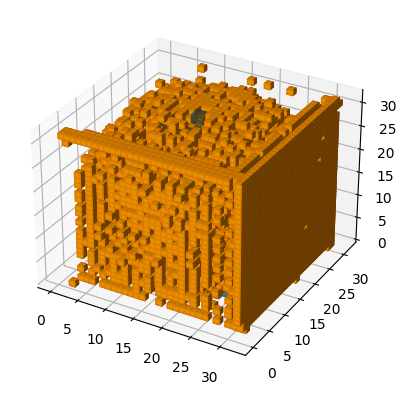

In [174]:
obj = torch.stack([models_tr_x[0], ])
pcs = gen(obj)

obj = obj[0][0].detach().cpu().numpy() > 0
pcs = pcs[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(obj, facecolors='darkslategray', alpha=0.5)
ax.voxels(pcs & ~obj, facecolors='orange', edgecolors='darkorange')
plt.show()

In [145]:
torch.save(dis.state_dict(), PATH_MODELS + '/dis.pth')
torch.save(gen.state_dict(), PATH_MODELS + '/gen.pth')